In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
import pandas as pd

# Assuming the CSV file is in the /content directory
file_path = '/content/drive/MyDrive/Credit card fraud detention /creditcard.csv'

# Read the CSV file into a DataFrame
df = pd.read_csv(file_path)

# Display the DataFrame
df.head()



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


0    284315
1       492
Name: Class, dtype: int64


<Axes: >

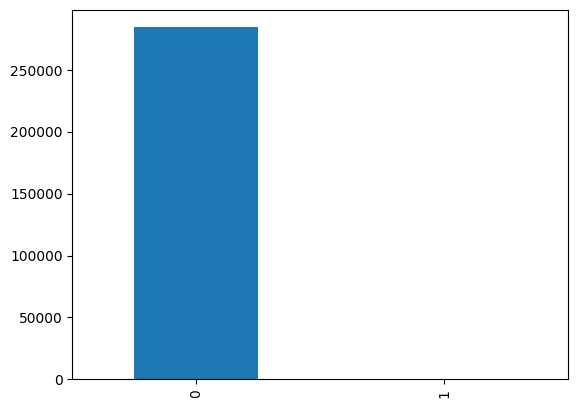

In [14]:
print(df.Class.value_counts())
df.Class.value_counts().plot(kind='bar')

In [15]:
from sklearn.ensemble import IsolationForest
from sklearn.model_selection import train_test_split

In [16]:
seed = 1337

def get_data(df, clean_train=True):
    """
        clean_train=True returns a train sample that only contains clean samples.
        Otherwise, it will return a subset of each class in train and test (10% outlier)
    """
    clean = df[df.Class == 0].copy().reset_index(drop=True)
    fraud = df[df.Class == 1].copy().reset_index(drop=True)
    print(f'Clean Samples: {len(clean)}, Fraud Samples: {len(fraud)}')

    if clean_train:
        train, test_clean = train_test_split(clean, test_size=len(fraud), random_state=seed)
        print(f'Train Samples: {len(train)}')

        test = pd.concat([test_clean, fraud]).reset_index(drop=True)

        print(f'Test Samples: {len(test)}')

        # shuffle the test data
        test.sample(frac=1, random_state=seed).reset_index(drop=True)

        train_X, train_y = train.loc[:, ~train.columns.isin(['Class'])], train.loc[:, train.columns.isin(['Class'])]
        test_X, test_y = test.loc[:, ~test.columns.isin(['Class'])], test.loc[:, test.columns.isin(['Class'])]
    else:
        clean_train, clean_test = train_test_split(clean, test_size=int(len(fraud)+(len(fraud)*0.9)), random_state=seed)
        fraud_train, fraud_test = train_test_split(fraud, test_size=int(len(fraud)*0.1), random_state=seed)

        train_samples = pd.concat([clean_train, fraud_train]).reset_index(drop=True)
        test_samples = pd.concat([clean_test, fraud_test]).reset_index(drop=True)

        # shuffle
        train_samples.sample(frac=1, random_state=seed).reset_index(drop=True)

        print(f'Train Samples: {len(train_samples)}')
        test_samples.sample(frac=1, random_state=seed).reset_index(drop=True)

        print(f'Test Samples: {len(test_samples)}')
        train_X, train_y = train_samples.loc[:, ~train_samples.columns.isin(['Class'])], train_samples.loc[:, train_samples.columns.isin(['Class'])]
        test_X, test_y = test_samples.loc[:, ~test_samples.columns.isin(['Class'])], test_samples.loc[:, test_samples.columns.isin(['Class'])]

    return train_X, train_y, test_X, test_y

train_X, train_y, test_X, test_y = get_data(df)

Clean Samples: 284315, Fraud Samples: 492
Train Samples: 283823
Test Samples: 984


In [17]:
model = IsolationForest(random_state=seed)
model.fit(train_X, train_y)

IsolationForest(random_state=1337)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

In [19]:
def predict(X):
    test_yhat = model.predict(X)
    # values are -1 and 1 (-1 for outliers and 1 for inliers), thus we will map it to 0 (inlier) and 1 (outlier) as this is our target variable
    test_yhat = np.array([1 if y == -1 else 0 for y in test_yhat])
    return test_yhat

test_yhat = predict(test_X)

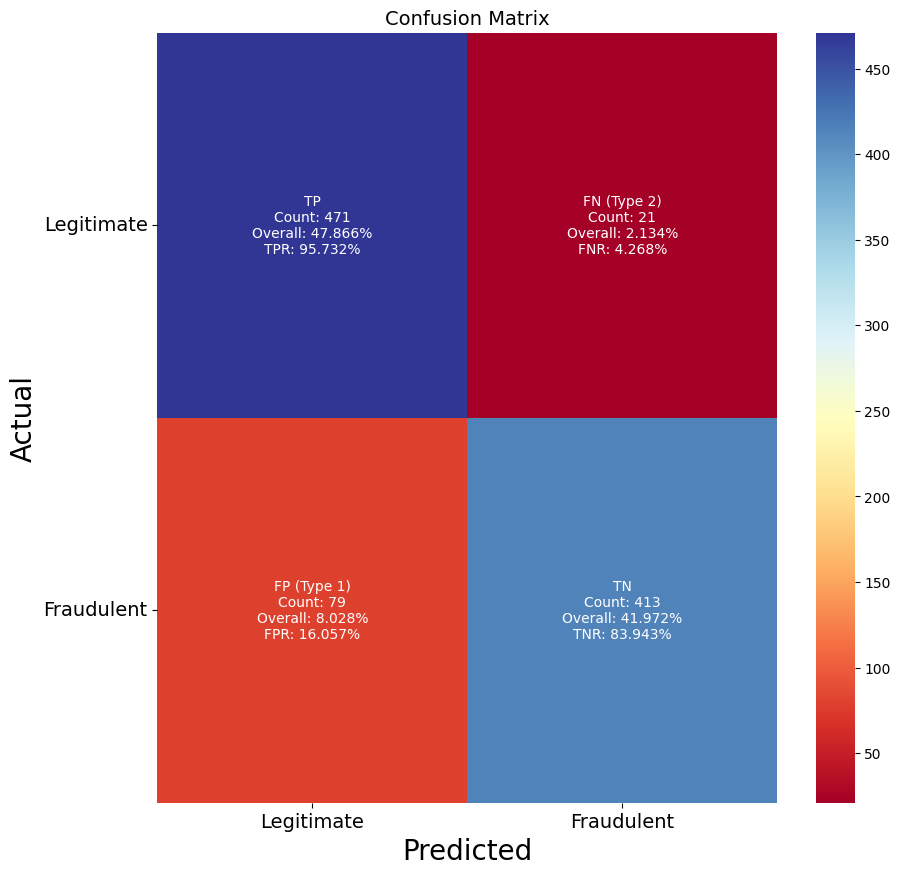

In [20]:
def get_confusion_matrix(test_y, test_yhat):
    cm = confusion_matrix(test_y, test_yhat)

    fig, ax = plt.subplots(1, 1,figsize=(10,10))

    tick_labels = ['Legitimate','Fraudulent']

    # calculate output
    total = np.sum(cm)
    tp = cm[0][0]
    fn = cm[0][1]
    fp = cm[1][0]
    tn = cm[1][1]
    tp_o = np.round((tp / total)*100,3)
    fn_o = np.round((fn / total)*100,3)
    fp_o = np.round((fp / total)*100,3)
    tn_o = np.round((tn / total)*100,3)
    tp_c = np.round(max((tp / (tp + fn)), 0.0)*100,3)
    fn_c = np.round(max((fn / (tp + fn)), 0.0)*100,3)
    fp_c = np.round(max((fp / (fp + tn)), 0.0)*100,3)
    tn_c = np.round(max((tn / (fp + tn)), 0.0)*100,3)
    labels = np.array([[
            f'TP\nCount: {tp}\nOverall: {tp_o}%\nTPR: {tp_c}%',
            f'FN (Type 2)\nCount: {fn}\nOverall: {fn_o}%\nFNR: {fn_c}%'
        ],[
            f'FP (Type 1)\nCount: {fp}\nOverall: {fp_o}%\nFPR: {fp_c}%',
            f'TN\nCount: {tn}\nOverall: {tn_o}%\nTNR: {tn_c}%'
        ]])
    sns.heatmap(cm, ax=ax, annot=labels, fmt='', cmap=plt.cm.RdYlBu)

    ax.set_title('Confusion Matrix', fontsize=14)

    ax.set_xticklabels(tick_labels, fontsize=14, rotation=0)
    ax.set_xlabel('Predicted', fontsize=20)
    ax.set_yticklabels(tick_labels, fontsize=14, rotation=0)
    ax.set_ylabel('Actual', fontsize=20)
    plt.show()

get_confusion_matrix(test_y, test_yhat)

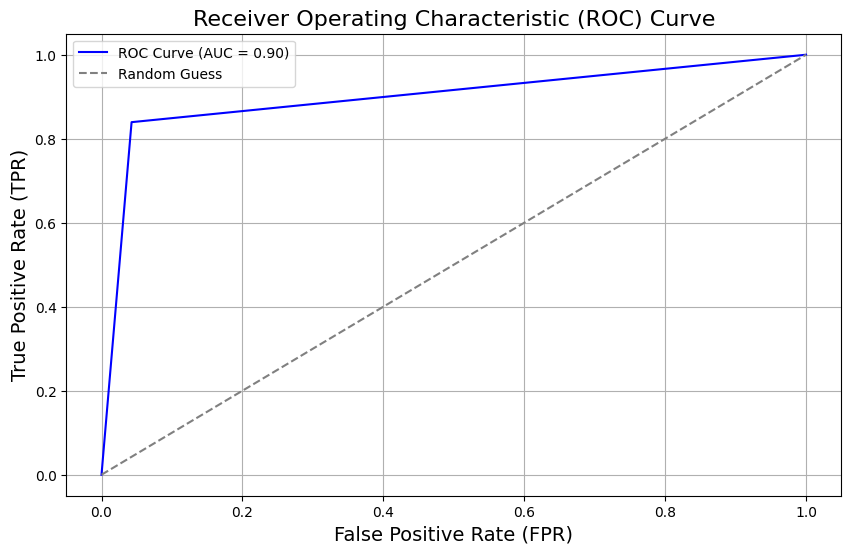

ROC AUC Score: 0.8984


In [21]:
from sklearn.metrics import roc_auc_score, roc_curve

# Calculate ROC AUC score
roc_auc = roc_auc_score(test_y, test_yhat)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(test_y, test_yhat)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Display ROC AUC score
print(f'ROC AUC Score: {roc_auc:.4f}')


In [25]:
# Display the total count of each class in the entire dataset
class_counts_df = df['Class'].value_counts()
print("Class Counts in the Entire Dataset:")
print(class_counts_df)


Class Counts in the Entire Dataset:
0    284315
1       492
Name: Class, dtype: int64


In [26]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Assuming 'Class' is your target variable and the rest are features
X = df.drop('Class', axis=1)
y = df['Class']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

# Apply SMOTE to the training set
smote = SMOTE(random_state=seed)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Now, you can train your model on the resampled training set, for example, using Logistic Regression
model = LogisticRegression(random_state=seed)
model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
test_predictions = model.predict(X_test)

# Evaluate the performance
print("Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, test_predictions))
print("\nClassification Report on Test Set:")
print(classification_report(y_test, test_predictions))


Confusion Matrix on Test Set:
[[55942   935]
 [    8    77]]

Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     56877
           1       0.08      0.91      0.14        85

    accuracy                           0.98     56962
   macro avg       0.54      0.94      0.57     56962
weighted avg       1.00      0.98      0.99     56962



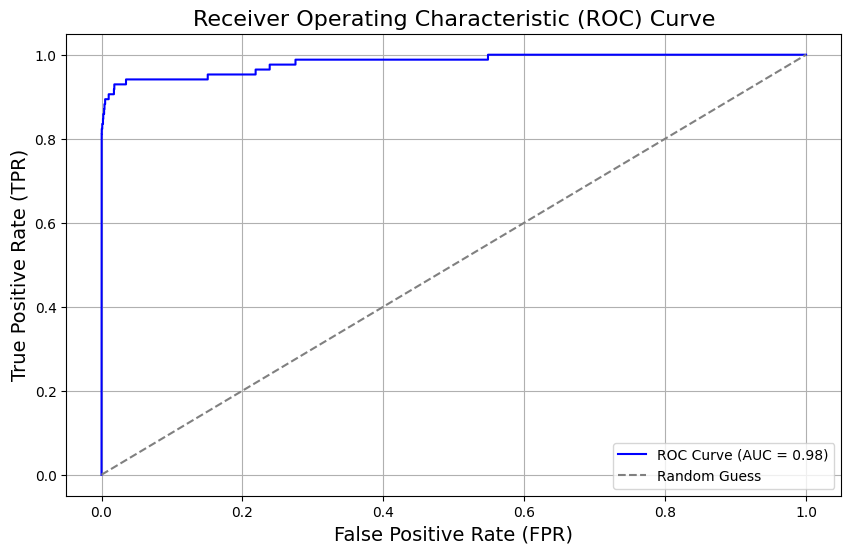

ROC AUC Score: 0.9819


In [27]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Make predictions on the test set with probabilities for ROC curve
test_probabilities = model.predict_proba(X_test)[:, 1]

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, test_probabilities)

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_test, test_probabilities)

# Plot ROC curve
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Display ROC AUC score
print(f'ROC AUC Score: {roc_auc:.4f}')


KNN Confusion Matrix on Test Set:
[[53542  3335]
 [   36    49]]

KNN Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      0.94      0.97     56877
           1       0.01      0.58      0.03        85

    accuracy                           0.94     56962
   macro avg       0.51      0.76      0.50     56962
weighted avg       1.00      0.94      0.97     56962



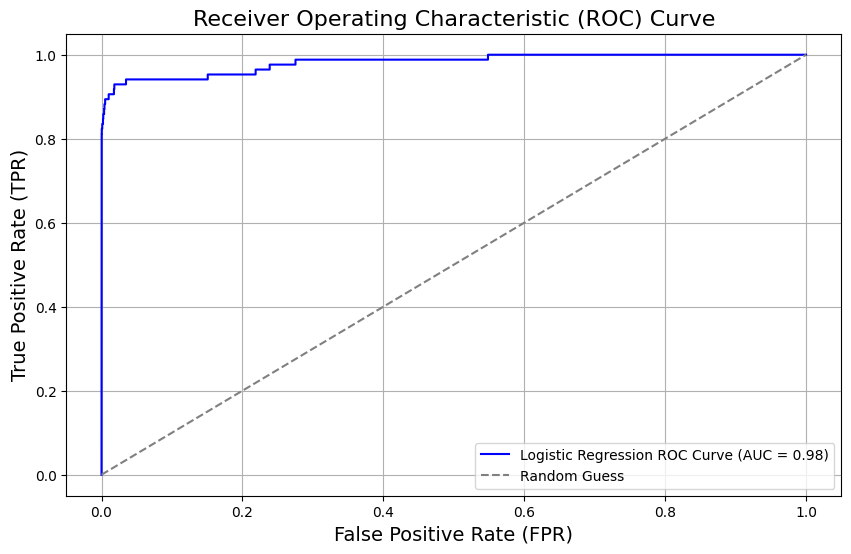

KNN ROC AUC Score: 0.7668


In [28]:
from sklearn.neighbors import KNeighborsClassifier

# Create KNN model
knn_model = KNeighborsClassifier()

# Train the KNN model on the resampled training set
knn_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
knn_test_predictions = knn_model.predict(X_test)

# Evaluate the performance of KNN
print("KNN Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, knn_test_predictions))
print("\nKNN Classification Report on Test Set:")
print(classification_report(y_test, knn_test_predictions))

# Calculate and plot ROC curve for KNN
knn_test_probabilities = knn_model.predict_proba(X_test)[:, 1]
knn_roc_auc = roc_auc_score(y_test, knn_test_probabilities)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Display KNN ROC AUC score
print(f'KNN ROC AUC Score: {knn_roc_auc:.4f}')


Decision Tree Confusion Matrix on Test Set:
[[56776   101]
 [   18    67]]

Decision Tree Classification Report on Test Set:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56877
           1       0.40      0.79      0.53        85

    accuracy                           1.00     56962
   macro avg       0.70      0.89      0.76     56962
weighted avg       1.00      1.00      1.00     56962



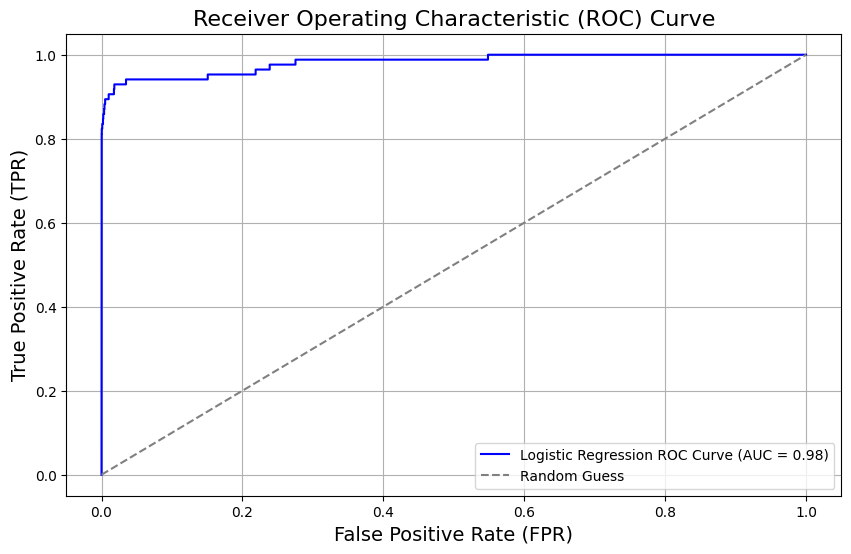

Decision Tree ROC AUC Score: 0.8932


In [29]:
from sklearn.tree import DecisionTreeClassifier

# Create Decision Tree model
tree_model = DecisionTreeClassifier(random_state=seed)

# Train the Decision Tree model on the resampled training set
tree_model.fit(X_train_resampled, y_train_resampled)

# Make predictions on the test set
tree_test_predictions = tree_model.predict(X_test)

# Evaluate the performance of Decision Tree
print("Decision Tree Confusion Matrix on Test Set:")
print(confusion_matrix(y_test, tree_test_predictions))
print("\nDecision Tree Classification Report on Test Set:")
print(classification_report(y_test, tree_test_predictions))

# Calculate and plot ROC curve for Decision Tree
tree_test_probabilities = tree_model.predict_proba(X_test)[:, 1]
tree_roc_auc = roc_auc_score(y_test, tree_test_probabilities)

plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, label=f'Logistic Regression ROC Curve (AUC = {roc_auc:.2f})', color='blue')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.title('Receiver Operating Characteristic (ROC) Curve', fontsize=16)
plt.xlabel('False Positive Rate (FPR)', fontsize=14)
plt.ylabel('True Positive Rate (TPR)', fontsize=14)
plt.legend()
plt.grid(True)
plt.show()

# Display Decision Tree ROC AUC score
print(f'Decision Tree ROC AUC Score: {tree_roc_auc:.4f}')
